## Weather Forecasting with Bayesian Network

#### Préparation des données

La préparation des données ainsi que leur discrétisation pour le réseau bayésien a donné lieu à plusieurs recherches afin de comprendre plus précisément le sujet.
- L'humidité est toujours en 0 et 1 (c'est un %)
- La vitesse du vent est généralement comprise entre 1 et 70 km/h
- La visibilité varie entre moins d'1 km et plus de 40km


In [33]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/weatherHistory.csv')

data = data.dropna()  # we have more than 10000 rows, we only have 517 rows with missing values, so we can drop them

data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data['Date'] = data['Formatted Date'].dt.date

data_grouped = data.groupby('Date').agg({
    'Summary': lambda x: x.mode()[0],
    'Precip Type': 'first',
    'Temperature (C)': 'median', 
    'Apparent Temperature (C)': 'median',
    'Humidity': 'mean',
    'Wind Speed (km/h)': 'mean',
    'Visibility (km)': 'mean',
}).reset_index()

data_grouped['Temperature (C)'] = data_grouped['Temperature (C)'].apply(lambda x: int(x))

data_grouped['Apparent Temperature (C)'] = data_grouped['Apparent Temperature (C)'].apply(lambda x: int(x))
data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])
data_grouped['WindSpeed_discrete'] = pd.cut(data_grouped['Wind Speed (km/h)'], bins=5,labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
data_grouped['Visibility_discrete'] = pd.cut(data_grouped['Visibility (km)'],bins=[0, 4, 10, data_grouped['Visibility (km)'].max()],labels=['Poor', 'Medium', 'High'], include_lowest=True)

data_grouped['Humidity_discrete'] = pd.cut(data_grouped['Humidity'], bins=3, labels=['Low', 'Medium', 'High'])

temp_min = data_grouped['Temperature (C)'].min()
temp_max = data_grouped['Temperature (C)'].max()
bins = np.arange(temp_min, temp_max + 2, 2)

data_grouped['Temperature_discrete'] = pd.cut(data_grouped['Temperature (C)'], bins=bins,labels=[f'{x}-{x+2}' for x in bins[:-1]], include_lowest=True)

data_discrete= data_grouped.drop(columns=[
    'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)'
]).set_index('Date')

data_discrete = data_discrete.rename(columns={
    'Temperature_discrete': 'Temperature',
    'Humidity_discrete': 'Humidity',
    'WindSpeed_discrete': 'WindSpeed',
    'Visibility_discrete': 'Visibility',
})

summary_categories = data_discrete['Summary'].unique()
data_discrete.head()

,Summary,Precip Type,Humidity,WindSpeed,Visibility,Temperature
Date,,,,,,
2005-12-31,Partly Cloudy,rain,High,Medium,Medium,-1-1
2006-01-01,Mostly Cloudy,rain,High,Medium,High,3-5
2006-01-02,Overcast,rain,High,Medium,Medium,3-5
2006-01-03,Overcast,rain,High,Very Low,Medium,1-3
2006-01-04,Overcast,rain,High,Low,Medium,1-3


In [34]:
category_mappings = {
    'Visibility': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Humidity': {'Low': 0, 'Medium': 1, 'High': 2},
    'WindSpeed': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Temperature':{f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Summary': {summary_categories[i] : i for i in range(len(summary_categories))},
    }

for column, mapping in category_mappings.items():
    data_discrete[column] = data_discrete[column].map(mapping)

print(data_discrete.head())

            Summary Precip Type Humidity WindSpeed Visibility Temperature
Date                                                                     
2005-12-31        0        rain        2         2          1           8
2006-01-01        1        rain        2         2          2          10
2006-01-02        2        rain        2         2          1          10
2006-01-03        2        rain        2         0          1           9
2006-01-04        2        rain        2         1          1           9


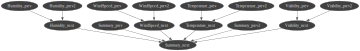

In [35]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

bn_predict = gum.BayesNet('WeatherPrediction')

# previous previous
temp_prev2 = bn_predict.add(gum.LabelizedVariable("Temperature_prev2", "Température avant veille", len(bins)))
hum_prev2 = bn_predict.add(gum.LabelizedVariable("Humidity_prev2", "Humidité avant veille", 3))
wind_prev2 = bn_predict.add(gum.LabelizedVariable("WindSpeed_prev2", "Vitesse avant veille", 5))
visib_prev2 = bn_predict.add(gum.LabelizedVariable("Visibility_prev2", "Visibilité avant veille", 3))
summary_prev2 = bn_predict.add(gum.LabelizedVariable("Summary_prev2", "Résumé avant veille", len(summary_categories)))

# previous
temp_prev = bn_predict.add(gum.LabelizedVariable("Temperature_prev", "Température du jour précédent", len(bins)))
hum_prev = bn_predict.add(gum.LabelizedVariable("Humidity_prev", "Humidité du jour précédent", 3))
wind_prev = bn_predict.add(gum.LabelizedVariable("WindSpeed_prev", "Vitesse du vent du jour précédent", 5))
visib_prev = bn_predict.add(gum.LabelizedVariable("Visibility_prev", "Visibilité du jour précédent", 3))
summary_prev = bn_predict.add(gum.LabelizedVariable("Summary_prev", "Résumé du jour précédent", len(summary_categories)))

# next
temp_next = bn_predict.add(gum.LabelizedVariable("Temperature_next", "Température du jour suivant", len(bins)))
hum_next = bn_predict.add(gum.LabelizedVariable("Humidity_next", "Humidité du jour suivant", 3))
wind_next = bn_predict.add(gum.LabelizedVariable("WindSpeed_next", "Vitesse du vent du jour suivant", 5))
visib_next = bn_predict.add(gum.LabelizedVariable("Visibility_next", "Visibilité du jour suivant", 3))
summary_next = bn_predict.add(gum.LabelizedVariable("Summary_next", "Résumé du jour suivant", len(summary_categories)))

bn_predict.addArc(temp_prev, temp_next)
bn_predict.addArc(hum_prev, hum_next)
bn_predict.addArc(wind_prev, wind_next)
bn_predict.addArc(visib_prev, visib_next)
bn_predict.addArc(summary_prev, summary_next)

bn_predict.addArc(temp_prev2, temp_next)
bn_predict.addArc(hum_prev2, hum_next)
bn_predict.addArc(wind_prev2, wind_next)
bn_predict.addArc(visib_prev2, visib_next)
bn_predict.addArc(summary_prev2, summary_next)

bn_predict.addArc(temp_next, summary_next)
bn_predict.addArc(hum_next, summary_next)
bn_predict.addArc(wind_next, summary_next)
bn_predict.addArc(visib_next, summary_next)

gnb.showBN(bn_predict)

In [36]:
data_predict = data_discrete.copy()

data_predict['Temperature_prev'] = data_discrete['Temperature'].shift(1)
data_predict['Humidity_prev'] = data_discrete['Humidity'].shift(1)
data_predict['WindSpeed_prev'] = data_discrete['WindSpeed'].shift(1)
data_predict['Visibility_prev'] = data_discrete['Visibility'].shift(1)
data_predict['Summary_prev'] = data_discrete['Summary'].shift(1).fillna(-1).astype(int)

data_predict['Temperature_prev2'] = data_discrete['Temperature'].shift(2)
data_predict['Humidity_prev2'] = data_discrete['Humidity'].shift(2)
data_predict['WindSpeed_prev2'] = data_discrete['WindSpeed'].shift(2)
data_predict['Visibility_prev2'] = data_discrete['Visibility'].shift(2)
data_predict['Summary_prev2'] = data_discrete['Summary'].shift(2).fillna(-1).astype(int)


data_predict = data_predict.rename(columns={
    'Temperature': 'Temperature_next',
    'Humidity': 'Humidity_next',
    'WindSpeed': 'WindSpeed_next',
    'Visibility': 'Visibility_next',
    'Summary': 'Summary_next'
})

data_predict.dropna(inplace=True)

data_predict.head()

,Summary_next,Precip Type,Humidity_next,WindSpeed_next,Visibility_next,Temperature_next,Temperature_prev,Humidity_prev,WindSpeed_prev,Visibility_prev,Summary_prev,Temperature_prev2,Humidity_prev2,WindSpeed_prev2,Visibility_prev2,Summary_prev2
Date,,,,,,,,,,,,,,,,
2006-01-02,2,rain,2,2,1,10,10,2,2,2,1,8,2,2,1,0
2006-01-03,2,rain,2,0,1,9,10,2,2,1,2,10,2,2,2,1
2006-01-04,2,rain,2,1,1,9,9,2,0,1,2,10,2,2,1,2
2006-01-05,2,rain,2,1,1,9,9,2,1,1,2,9,2,0,1,2
2006-01-06,2,rain,2,0,1,9,9,2,1,1,2,9,2,1,1,2


In [37]:
learner = gum.BNLearner(data_predict, bn_predict)

learner.useSmoothingPrior(0.5)
bn_predict_learned = learner.learnParameters(bn_predict)

# gnb.showPotential(bn_predict_learned.cpt("Temperature_next"))

In [38]:
category_mappings_predict = {
    'Visibility_prev': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Visibility_prev2': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Visibility_next': {'Poor': 0, 'Medium': 1, 'High': 2},
    'Humidity_prev': {'Low': 0, 'Medium': 1, 'High': 2},
    'Humidity_prev2': {'Low': 0, 'Medium': 1, 'High': 2},
    'Humidity_next': {'Low': 0, 'Medium': 1, 'High': 2},
    'WindSpeed_prev': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'WindSpeed_prev2': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'WindSpeed_next': {'Very Low': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4},
    'Temperature_prev': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Temperature_prev2': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Temperature_next': {f'{bins[i]}-{bins[i+1]}': i for i in range(len(bins) - 1)},
    'Summary_prev': {summary_categories[i]: i for i in range(len(summary_categories))},
    'Summary_prev2': {summary_categories[i]: i for i in range(len(summary_categories))},
    'Summary_next': {summary_categories[i]: i for i in range(len(summary_categories))}
}

def predict_next_day(date_str):

    date = pd.to_datetime(date_str).date()
    if date not in data_predict.index:
        raise ValueError(f"La date {date} n'est pas présente dans le dataset.")
    
    prev_data = data_predict.loc[date, ['Temperature_prev', 'Humidity_prev', 'WindSpeed_prev', 'Visibility_prev', 'Summary_prev',
                                        'Temperature_prev2', 'Humidity_prev2', 'WindSpeed_prev2', 'Visibility_prev2', 'Summary_prev2']]
    
    evidence = {
        "Temperature_prev": int(prev_data['Temperature_prev']),
        "Humidity_prev": int(prev_data['Humidity_prev']),
        "WindSpeed_prev": int(prev_data['WindSpeed_prev']),
        "Visibility_prev": int(prev_data['Visibility_prev']),
        "Summary_prev": int(prev_data['Summary_prev']),

        "Temperature_prev2": int(prev_data['Temperature_prev2']),
        "Humidity_prev2": int(prev_data['Humidity_prev2']),
        "WindSpeed_prev2": int(prev_data['WindSpeed_prev2']),
        "Visibility_prev2": int(prev_data['Visibility_prev2']),
        "Summary_prev2": int(prev_data['Summary_prev2']),
    }
    
    ie = gum.LazyPropagation(bn_predict_learned)
    ie.setEvidence(evidence)
    ie.makeInference()
    
    predictions = {}

    for var in ["Summary_next", "Temperature_next", "Humidity_next", "WindSpeed_next", "Visibility_next"]:
        
        posterior = ie.posterior(var)
        predicted_state = posterior.argmax()[0][0]
        probability = posterior.argmax()[1]

        # Traduction
        inverse_mapping = {
            "Summary_next": {v: k for k, v in category_mappings_predict['Summary_next'].items()},
            "Temperature_next": {v: k for k, v in category_mappings_predict['Temperature_next'].items()},
            "Humidity_next": {v: k for k, v in category_mappings_predict['Humidity_next'].items()},
            "WindSpeed_next": {v: k for k, v in category_mappings_predict['WindSpeed_next'].items()},
            "Visibility_next": {v: k for k, v in category_mappings_predict['Visibility_next'].items()}
        }[var]
        predicted_category = inverse_mapping[predicted_state.get(var)]
        predictions[var] = (predicted_category, probability * 100)
    
    return predictions


In [43]:
##PAs ouf ça

from sklearn.metrics import accuracy_score, f1_score

inverse_mapping = {
            "Summary_next": {v: k for k, v in category_mappings_predict['Summary_next'].items()},
            "Temperature_next": {v: k for k, v in category_mappings_predict['Temperature_next'].items()},
            "Humidity_next": {v: k for k, v in category_mappings_predict['Humidity_next'].items()},
            "WindSpeed_next": {v: k for k, v in category_mappings_predict['WindSpeed_next'].items()},
            "Visibility_next": {v: k for k, v in category_mappings_predict['Visibility_next'].items()}
}

def evaluate_summary_accuracy(start_date, end_date):
    true_values = []
    pred_values = []

    for date in pd.date_range(start=start_date, end=end_date):
        date_str = date.strftime('%Y-%m-%d')
        try:
            true_val = data_predict.loc[date.date(), "Summary_next"]
            true_values.append(int(true_val))

            pred_val = predict_next_day(date_str)["Summary_next"][0] 
            pred_values.append(pred_val)
        except ValueError:
            continue
    
    true_values = [inverse_mapping['Summary_next'][value] for value in true_values]

    accuracy = accuracy_score(true_values, pred_values)
    return accuracy

# Évaluation de l'exactitude pour "Summary"
start_date = "2016-09-01"
end_date = "2016-10-10"
summary_accuracy = evaluate_summary_accuracy(start_date, end_date)
print(f"Exactitude pour 'Summary': {summary_accuracy:.2f}")


Exactitude pour 'Summary': 0.42


In [ ]:
import numpy as np

def mse_temperature(data, bn_model):
    squared_errors = []

    for _, row in data.iterrows():
        ie = gum.LazyPropagation(bn_model)
        
        evidence = {
            "Temperature_prev": int(row['Temperature_prev']),
            "Humidity_prev": int(row['Humidity_prev']),
            "WindSpeed_prev": int(row['WindSpeed_prev']),
            "Visibility_prev": int(row['Visibility_prev']),
            "Summary_prev": int(row['Summary_prev']),
            "Temperature_prev2": int(row['Temperature_prev2']),
            "Humidity_prev2": int(row['Humidity_prev2']),
            "WindSpeed_prev2": int(row['WindSpeed_prev2']),
            "Visibility_prev2": int(row['Visibility_prev2']),
            "Summary_prev2": int(row['Summary_prev2']),
        }
        ie.setEvidence(evidence)
        ie.makeInference()
        
        # Récupérer la distribution de probabilités pour Temperature_next
        posterior_temp = ie.posterior("Temperature_next")
        
        # Calculer la prédiction continue comme moyenne pondérée des valeurs discrètes
        predicted_temperature = sum(
            state * posterior_temp[state] for state in range(len(posterior_temp))
        )
        
        # Valeur réelle de Temperature_next pour cette observation
        actual_temperature = int(row["Temperature_next"])
        
        # Calculer l'erreur quadratique
        squared_error = (predicted_temperature - actual_temperature) ** 2
        squared_errors.append(squared_error)
    
    # Calculer la MSE en prenant la moyenne des erreurs quadratiques
    mse = np.mean(squared_errors)
    return mse

# Exemple d'évaluation de la MSE
data_sample = data_predict.sample(frac=0.1, random_state=42)
mse_score = mse_temperature(data_sample, bn_predict_smoothed)
print(f"Erreur quadratique moyenne (MSE) pour Temperature_next : {mse_score:.2f}")


In [25]:
date_to_predict = "2016-09-11"
predictions = predict_next_day(date_to_predict)
print(f"On the {date_to_predict},")
for var, (category, prob) in predictions.items():
    print(f"{var}: {category} avec une probabilité de {prob:.2f}%")

On the 2016-09-11,
Summary_next: Partly Cloudy avec une probabilité de 21.50%
Temperature_next: 23-25 avec une probabilité de 30.57%
Humidity_next: Medium avec une probabilité de 75.94%
WindSpeed_next: Very Low avec une probabilité de 49.69%
Visibility_next: High avec une probabilité de 88.25%
